In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.cm as cm
%matplotlib widget

import numpy as np
from numpy.linalg import norm
import math
import pandas as pd
from tqdm import tqdm
from photutils.centroids import centroid_com, centroid_2dg, centroid_sources
from astroquery.vizier import Vizier
import astropy.units as u
import astropy.coordinates as coord
from PIL import Image
import os
from scipy.fft import rfft, rfftfreq
import scipy.stats as stats
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from AstroTUBIN_functions import *
#load_png_images, load_badpixelmap, detect_hotpxl_bw, correct_hotpxl, check_if_badpxl, 

#import seaborn as sns
#from scipy.interpolate import interp1d
#from scipy.interpolate import CubicSpline

: 

In [2]:
def load_png_images(path):
    image_list = []
    times = []
    for filename in sorted(os.listdir(path)):
        if filename.endswith('.png'):
            #img_file = get_pkg_data_filename(path + filename)
            img = plt.imread(path + filename)#fits.getdata(img_file)
            print(filename)
            image_list.append(img*65536)
            
            time_str = os.path.splitext(filename)[0][-12:]
            time = int(time_str[:2])*60*60 + int(time_str[2:4])*60 + int(time_str[4:6])
            times.append(time)
    times = np.array(times)-times[0]
    return np.array(image_list), times


def load_badpixelmap():

    #check if bad pixel map file exist and load
    if os.path.exists('mask_weights.npy'):

        mask_weights = np.load('mask_weights.npy')
        print('existing bad pixel map file loaded')
    else:

        print('generating bad pixel map file')

        mask = detect_hotpxl_bw(bw_images[0])
        print('1st image analysed')

        mask1 = detect_hotpxl_bw(bw_images[1])
        print('2nd image analysed')

        mask2 = detect_hotpxl_bw(bw_images[2])
        print('3rd image analysed')

        mask_weights = (mask + mask1 + mask2)/3

    np.save('mask_weights', mask_weights)
    print('bad pixel map file generated and loaded')

    return mask_weights


def detect_hotpxl_bw(img):
    
    width = img.shape[0]
    height = img.shape[1]
    
    mask = np.zeros((width, height))
    
    edge_pxl = 1
    hotpxl_lower_thres = 9500
    bkg_noise_thres = 7000
    
    ring_pxl_radius = 1
        
        #print('Analysing channel ' + str(channel))
        
    for i in tqdm(range(width)):
        for j in range(height):
                
            center = img[i,j]
                
            if center < bkg_noise_thres: continue
            
            ring_weight = 0
            ring_weight_sum = 0
            ring_pxl = 0
            bkg_pxl = 0
            
            for m in range(-ring_pxl_radius, ring_pxl_radius+1):
                for n in range(-ring_pxl_radius, ring_pxl_radius+1):
                        
                    if abs(m) == 1 or abs(n) == 1:
                        if (i+m >= 0 and i+m < width) and (j+n >= 0 and j+n < height):
                                #neighbor_max = max(neighbor_max, temp_img[i+m, j+n])
                            if img[i+m, j+n] < bkg_noise_thres:
                                bkg_pxl += 1
                
            if bkg_pxl > 4:
                mask[i, j] = 1      

    return mask


def correct_hotpxl(img, mask_weights):
    
    #print(img.shape)
    
    width = img.shape[1]
    height = img.shape[0]
    
    corr_img = np.copy(img)
    
    for i in tqdm(range(height)):
            for j in range(width):
                
                neighbor_weight = neighbor_pxl = 0
                
                if mask_weights[i,j] != 0:
                    
                    for m in range(-1, 2):
                        for n in range(-1,2):
                        
                            if abs(m) == 1 or abs(n) == 1:
                                if (i+m >= 0 and i+m < height) and (j+n >= 0 and j+n < width):
                                    if img[i+m, j+n] < 20000:
                                        neighbor_weight += img[i+m, j+n]
                                        neighbor_pxl += 1
                                    else:
                                        neighbor_weight += 20000
                                        neighbor_pxl += 1
                                        
                    
                    #print(neighbor_weight, neighbor_pxl)
                    neighbor_mean = neighbor_weight/neighbor_pxl
                    
                    corr_img[i,j] = img[i,j] - (img[i,j]-neighbor_mean)*mask_weights[i,j]
                    
    return corr_img


def check_if_badpxl(img, x, y):
    
    width = img.shape[0]
    height = img.shape[1]
      
    if x.shape[0] > 1:
        
        bad_pxl_idx = np.array([]).astype('int')
        
        for i in range(x.shape[0]): 
        
            if np.isnan(x[i]): continue
        
            x_pxl = int(round(y[i],0))
            y_pxl = int(round(x[i],0))
                
            center = img[x_pxl, y_pxl]
        
            neighbor_sum = 0
            neighbor_pxl = 0
        
            for m in range(-1, 2):
                for n in range(-1, 2):
                    if abs(m) == 1 or abs(n) == 1:
                        if (x_pxl+m >= 0 and x_pxl+m < width) and (y_pxl+n >= 0 and y_pxl+n < height):
                            neighbor_sum += img[x_pxl+m, y_pxl+n]
                            neighbor_pxl += 1
        
            neighbor_mean = neighbor_sum/neighbor_pxl
        
            if neighbor_mean < 6000 and center > 25000: 
                bad_pxl_idx = np.append(bad_pxl_idx, int(i))
            elif center < 5000:
                bad_pxl_idx = np.append(bad_pxl_idx, int(i))
                
        x, y = np.delete(x, bad_pxl_idx), np.delete(y, bad_pxl_idx)
                
    else:
        
            x_pxl = int(round(y[0],0))
            y_pxl = int(round(x[0],0))
                
            center = img[x_pxl, y_pxl]
        
            neighbor_sum = 0
            neighbor_pxl = 0
        
            for m in range(-1, 2):
                for n in range(-1, 2):
                    
                    if abs(m) == 1 or abs(n) == 1:
                        if (x_pxl+m >= 0 and x_pxl+m < width) and (y_pxl+n >= 0 and y_pxl+n < height):
                            neighbor_sum += img[x_pxl+m, y_pxl+n]
                            neighbor_pxl += 1
        
            neighbor_mean = neighbor_sum/neighbor_pxl
        
            if neighbor_mean < 6000 and center > 25000: 
                x, y = np.delete(x, 0), np.delete(y, 0)
            elif center < 5000:
                x, y = np.delete(x, 0), np.delete(y, 0)
        
    return x, y


def find_centroids(tpf, box=21, star_thres = 5000):
    
    mask_tpf = np.where(tpf<star_thres, 0, tpf)
    
    init_grid_step = 5
    x, y = np.meshgrid(np.arange(init_grid_step/2, tpf.shape[0], init_grid_step), np.arange(init_grid_step/2, tpf.shape[1], init_grid_step))
    
    x = np.reshape(x, (1, x.size))[0]
    y = np.reshape(y, (1, y.size))[0]
    
    reduction = x.size 
    iteration = 0
    centroids = x.size
    
    while reduction != 0:
        
        if np.isnan(x).all() or np.isnan(y).all(): 
            break
        
        x = x[~np.isnan(x)]
        y = y[~np.isnan(y)]

        x = np.unique(np.around(x, 0))
        y = np.unique(np.around(y, 0))
    
        x, y = centroid_sources(mask_tpf, x , y, centroid_func=centroid_com, box_size=box)
    
        reduction = centroids-x.size
        centroids = x.size
        iteration += 1
    
        if iteration > 10: break
    
    x, y = check_if_badpxl(tpf, x, y)
    
    return x, y


def find_centroid_coord(img, tpf_size = 40):
    
    if np.max(img) <= 1:
        star_thres=5000/65536
    else:
        star_thres=5000
    
    centroid_x, centroid_y = np.array([]), np.array([])

    for i in tqdm(np.arange(tpf_size/2, img.shape[0]-tpf_size/2, tpf_size*0.65)):
        for j in np.arange(tpf_size/2, img.shape[1]-tpf_size/2, tpf_size*0.65):
        
            down = int((i-tpf_size/2))
            up = int((i+tpf_size/2))
            left = int((j-tpf_size/2))
            right = int((j+tpf_size/2))
        
            tpf = img[down:up, left:right]
        
            x, y = find_centroids(tpf, 21, star_thres)
            xs, ys = find_centroids(tpf, 13, star_thres)
            
            x = np.append(x, xs)#x + xs
            y = np.append(y, ys)#y + ys
        
            if np.isnan(x).any(): continue
        
            glob_x = j-tpf_size/2+x
            glob_y = i-tpf_size/2+y
        
            centroid_x = np.append(centroid_x, glob_x)
            centroid_y = np.append(centroid_y, glob_y)

    centroid_xy = np.array([[i, j] for i, j in zip(centroid_x, centroid_y) if i-j != int(i)-int(j)])
    
    centroid_xy = centroid_xy[centroid_xy[:,0].argsort()]
    #print(centroid_xy)
    dub_idx = []
    
    merged_centroids = []
    for coord in centroid_xy:
        merged = False
        for existing in merged_centroids:
            if ((coord[0] - existing[0])**2 + (coord[1] - existing[1])**2)**0.5 < 10:
                existing[0] = (existing[0] + coord[0]) / 2.0
                existing[1] = (existing[1] + coord[1]) / 2.0
                merged = True
                break
        if not merged:
            merged_centroids.append(coord)
    
    centroid_xy = np.array(merged_centroids)
    #print('adjust centroid positions ...')
    
    mask_img = np.where(img < star_thres, 0, img)
    
    x, y = centroid_sources(mask_img, centroid_xy[:,0], centroid_xy[:,1], centroid_func=centroid_com, box_size=13)
    
    clean_xy = np.array([[i, j] for i, j in zip(x, y) if i > 50 and i < (img.shape[1]-50) and j > 50 and j < (img.shape[0]-50)])
    

    return clean_xy


def generate_tpf(img, xy):
    
    tpf_size=40
    
    tpf_file = np.zeros((1, tpf_size, tpf_size))
    n = 0
    
    for i, j in xy:
        
        down = int(round((i-tpf_size/2),0))
        up = int(round((i+tpf_size/2), 0))
        left = int(round((j-tpf_size/2), 0))
        right = int(round((j+tpf_size/2), 0))
    
        tpf = img[left:right, down:up]
        
        #print(xy.shape, n)
        
        tpf_file = np.vstack([tpf_file, [tpf]])
        
        n += 1    
    
    return tpf_file[1:]    


def create_starlight_curve(tpf, xy):
    
    r_flux = []
    
    #print(tpf)
    
    c = [tpf.shape[0]//2, tpf.shape[1]//2]
    c_corr = [xy[0]-round(xy[0],0), xy[1]-round(xy[1],0)]
    
    #radius_star = r*0.5 
    #radius_bg_in = radius_star+2 
    #radius_bg_out = 19
    
    for i in range(-tpf.shape[0]//2, tpf.shape[0]//2):
            for j in range(-tpf.shape[1]//2, tpf.shape[1]//2):
                
                #print(i,j)
                
                r_flux.append([math.sqrt((i-c_corr[0])**2 + (j-c_corr[1])**2), tpf[c[0]+i, c[1]+j]])
    
    r_flux = np.array(r_flux)
    
    return np.array(r_flux[r_flux[:, 0].argsort()]) 


def get_rad_lightcurves(tpfs, xy):

    lc = []

    for n, i in tqdm(enumerate(tpfs), total=xy.shape[0]):
        #print(n,i)
        #tpf_psf = []
        r_fl = []
    
        for m, j in enumerate(i):
            #print(m,j)
            lcv_star = create_starlight_curve(j, xy[n][m])
            r_fl.append(lcv_star)
            #print(r_fl)
        #print(len(lightcurves))
        lc.append(np.array(r_fl))
    
    return np.array(lc, dtype=object)


def measure_star(lc):
    
    aperture = []
    flux = []
    mean_curve = []
    bkgnoise = []
    
    bkg_out_radius = 18
    bkg_in_radius = 10
    
    for img in lc:
        img_ap = []
        img_flux = []
        img_meanc = []
        img_bkgnoise = []
        
        for star_lc in img:
            
            bkg = star_lc[np.where((star_lc[:,0] < bkg_out_radius) & (star_lc[:,0] > bkg_in_radius))][:,1]
            bkg_mean = np.mean(bkg)
            bkg_noise = np.std(bkg)
            
            star_mean_curve = []
            step_size = 1
    
            for i in np.arange(0,20, step_size):
        
                star_mean_curve.append([i+step_size/2, np.mean(star_lc[(i+step_size>star_lc[:,0]) & (i<=star_lc[:,0])], axis=0)[1]])
    
            star_mean_curve = np.array(star_mean_curve)
        
            inter_star = interp1d(star_mean_curve[:,1], star_mean_curve[:,0])

            half_peak = (np.mean(star_mean_curve[:2,1]) - bkg_mean)/2 + bkg_mean
            #print(half_peak, bkg_mean, star_lc[np.where((star_lc[:,0] < bkg_out_radius) & (star_lc[:,0] > bkg_in_radius))])
            fwhm = np.around(inter_star(half_peak),1)

            ap_factor = 2.2
            
            ap = max(min(np.round(ap_factor * fwhm * 2) / 2, 7), 2)
            
            ap_pxl = star_lc[:,1][np.where(star_lc[:,0] < ap)]
            ap_flux = np.sum(ap_pxl)
            ap_mean = np.mean(ap_pxl)
            
            star_flux = (ap_mean - bkg_mean)*ap_pxl.shape[0]
            
            img_flux.append(star_flux)
            img_ap.append(ap)
            img_meanc.append(star_mean_curve)
            img_bkgnoise.append((np.sqrt(bkg_noise*ap_pxl.shape[0]), bkg_mean))
        
        aperture.append(np.array(img_ap))
        flux.append(np.array(img_flux))
        mean_curve.append(np.array(img_meanc))
        bkgnoise.append(np.array(img_bkgnoise))
    
    return np.array(aperture, dtype=object), np.array(flux, dtype=object), np.array(mean_curve, dtype=object), np.array(bkgnoise, dtype=object)


def reduce_data(data, mag_limit = 10.5, rad_limit = 2.75):


    for i in range(data[0].shape[0]):
        
        red_idx = np.intersect1d(np.where(np.log(data[1][i]) > mag_limit), np.where(data[2][i] >= rad_limit))
    
        if i == 0:
            red_data = np.array([data[0][i][red_idx], data[1][i][red_idx], data[2][i][red_idx], data[3][i][red_idx], data[4][i][red_idx], data[5][0][i][red_idx][None]], dtype=object)
        else:
            red_data = np.vstack([red_data, np.array([data[0][i][red_idx], data[1][i][red_idx], data[2][i][red_idx], data[3][i][red_idx], data[4][i][red_idx], data[5][0][i][red_idx][None]], dtype=object)])
        
    return red_data


def pxl_to_angle(pxl_coord, focal_length = 22.8766, pixel_size = 0.00166995, sensor_size = np.array([4.589, 6.119])):
    
    theta = (pxl_coord[:,0] * pixel_size - 0.5 * sensor_size[1]) / focal_length
    phi = (pxl_coord[:,1] * pixel_size - 0.5 * sensor_size[0]) / focal_length
    
    ra = theta
    dec = -phi#-np.arctan(phi / np.sqrt(1 + theta**2 + phi**2))
    
    return ra, dec


def camera_angle(xy, focal_length = 22.8766, pixel_size = 0.00166995, sensor_size = np.array([4.589, 6.119])):
    
    radec = []
    
    for i in xy:
        
        u = i[:,0] - 0.5 * flat_img.shape[1]
        v = i[:,1] - 0.5 * flat_img.shape[0]
        
        r = np.sqrt(u**2 + v**2)
        K1 = -0.1781
        
        theta = u * (1 + K1*(r/(focal_length/pixel_size))**2) /(focal_length/pixel_size)
        phi = v * (1 + K1*(r/(focal_length/pixel_size))**2) /(focal_length/pixel_size)
        
        ra = np.degrees(np.arctan(theta))
        dec = -np.degrees(np.arctan(phi))
        
        radec.append(np.column_stack([ra, dec]))
    
    return np.array(radec, dtype=object)


def create_triangles(coord):
    
    triangles_x =  [0,0,0]
    triangles_y =  [0,0,0]
    angles = [0,0]
    
    for i in range(coord.shape[1]):
        
        for j in range(coord.shape[1]):
            
            for k in range(coord.shape[1]):
                
                if  i < j < k:
                    
                    a = math.sqrt((coord[0,j] - coord[0,k])**2 + (coord[1,j] - coord[1,k])**2)
                    b = math.sqrt((coord[0,i] - coord[0,k])**2 + (coord[1,i] - coord[1,k])**2)
                    c = math.sqrt((coord[0,i] - coord[0,j])**2 + (coord[1,i] - coord[1,j])**2)
                    
                    A = math.degrees(math.acos((b**2 + c**2 - a**2) / (2*b*c))) 
                    B = math.degrees(math.acos((a**2 + c**2 - b**2) / (2*a*c)))
                    C = math.degrees(math.acos((a**2 + b**2 - c**2) / (2*a*b)))
                    
                    highest_angle = np.max([A, B, C])
                    smallest_angle = np.min([A, B, C])
                    
                    if A == smallest_angle:
                        triangles_x = np.vstack([triangles_x, np.array([coord[0,j], coord[0,k], coord[0,i]])])
                        triangles_y = np.vstack([triangles_y, np.array([coord[1,j], coord[1,k], coord[1,i]])])
                        angles = np.vstack([angles, [highest_angle, smallest_angle]])
                    elif B == smallest_angle:
                        triangles_x = np.vstack([triangles_x, np.array([coord[0,i], coord[0,k], coord[0,j]])])
                        triangles_y = np.vstack([triangles_y, np.array([coord[1,i], coord[1,k], coord[1,j]])])
                        angles = np.vstack([angles, [highest_angle, smallest_angle]])
                    elif C == smallest_angle:
                        triangles_x = np.vstack([triangles_x, np.array([coord[0,i], coord[0,j], coord[0,k]])])
                        triangles_y = np.vstack([triangles_y, np.array([coord[1,i], coord[1,j], coord[1,k]])])
                        angles = np.vstack([angles, [highest_angle, smallest_angle]])
                    
    return triangles_x[1:], triangles_y[1:], angles[1:]  


def find_corresponding_triangle(xy1, xy2, mode):
    
    conn_coord = np.array([0,0,0,0])
    
    
    
    if mode == 0:
        tol = 0.05
        minimum_star_count = 15 #15 FIX THIS PARAMETER TO INGNORE HOT PIXELS
    elif mode == 1:
        tol = 0.21#0.05
        minimum_star_count = np.around(xy1[0].shape[0]**(1/3)-6, 0)#13
        
    #print('minimum star count: {:.0f}'.format(minimum_star_count))

    for i in range(xy1[0].shape[0]):
        
        angle_diff = abs(xy2[2][:, 1]-xy1[2][i,1])
        h_angle_diff = abs(xy2[2][:, 0]-xy1[2][i,0])
        
        dist = np.sqrt(angle_diff**2 + h_angle_diff**2)
        idx = np.where(dist < tol)[0]
        
        if idx.size == 1: 
            conn_coord = np.vstack([conn_coord, np.array([xy1[0][i,2], xy1[1][i,2], xy2[0][int(idx),2], xy2[1][int(idx),2]])])
    
    a, b = np.unique(conn_coord[1:], axis=0, return_counts=True)
    #print(a,b)
        
    confirmed_coord = np.array([i for i, j in zip(a, b) if j > minimum_star_count])
            
    if np.unique(confirmed_coord[:,1], axis=0).shape[0] > np.unique(confirmed_coord[:,2], axis=0).shape[0]: 
        print('at least one star identification is wrong')
        #print(conn_coord, xy1[0])
        c, d = np.unique(confirmed_coord[:,2:4], axis=0, return_counts=True)
        print('double coordinate:\n' + str(c[np.where(d>1)]))
        #print('location in conn coord:\n' + str(d))
        print('no. of confirmed stars:\n' + str(np.unique(b)) + '\n thres:\n' + str(minimum_star_count))
        
    return confirmed_coord   


def best_fit_transform(A, B):
    
    assert A.shape == B.shape, "Input arrays must have the same shape."
    N = A.shape[0]

    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)

    AA = A - centroid_A
    BB = B - centroid_B
    
    AA_dist = np.linalg.norm(AA, axis=1)
    #BB_dist = np.linalg.norm(BB, axis=1)
    
    AA = AA[AA_dist<5.5]
    BB = BB[AA_dist<5.5]

    H = np.dot(AA.T, BB).astype('float64')

    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    if np.linalg.det(R) < 0:
        Vt[1,:] *= -1
        R = np.dot(Vt.T, U.T)
    
    t = centroid_B.T - np.dot(R,centroid_A.T)

    T = t.reshape((1,2))
    T[:, 0] *= -1
    
    theta = np.degrees(np.arctan2(R[1,0], R[0,0]))
    
    return T[0], theta


def match_images(rd, data, mode=0):

    print('creating time series...')

    displacement = []
    rot_angle = []
    flux_time = []
    conn_stars = []
    ap = []
    res = []
    rad_star_curve = []

    ref_idx = 0
    
    print('analyse reference image...')
    if mode == 0:
        ref_coord = np.array([rd[ref_idx][:,0], rd[ref_idx][:,1]])
    elif mode == 1:
        ref_coord = np.array([norm_star_coord[:,0], norm_star_coord[:,1]])
        
    tri1 = create_triangles(ref_coord)
    

    for n, i in tqdm(enumerate(rd), total=rd.shape[0]):
    
        #os.system('clear')
        #tqdm._instances.clear()
        #print('matching img id: ' + str(n))
        det_coord = np.array([i[:,0], i[:,1]])
        #ref_coord = np.array([rd[ref_idx][:,0], rd[ref_idx][:,1]])
    
        tri = create_triangles(det_coord)
        #tri1 = create_triangles(ref_coord)
        #print(tri1, tri)
        conn_coord = find_corresponding_triangle(tri, tri1, mode)
        
    
        flux_timestep = [0] * ref_coord.shape[1]
        ap_timestep = [0] * ref_coord.shape[1]
        rsc_timestep = [0] * ref_coord.shape[1]
            

        
        if mode == 0:
            for m in range(conn_coord.shape[0]):
    
                flux_timestep[np.where(rd[ref_idx]==conn_coord[m,2:4])[0][0]] = data[n+ref_idx][1][np.where(rd[ref_idx+n]==conn_coord[m,0:2])[0]][0]
                ap_timestep[np.where(rd[ref_idx]==conn_coord[m,2:4])[0][0]] = data[n+ref_idx][2][np.where(rd[ref_idx+n]==conn_coord[m,0:2])[0]][0]
                rsc_timestep[np.where(rd[ref_idx]==conn_coord[m,2:4])[0][0]] = data[n+ref_idx][4][np.where(rd[ref_idx+n]==conn_coord[m,0:2])[0]][0]
                
        elif mode == 1:
            for m in range(conn_coord.shape[0]):
                
                #print(conn_coord, ref_coord.T, np.where(norm_star_coord==conn_coord[m,2:4])[0][0], len(flux_timestep))
    
                flux_timestep[np.where(norm_star_coord==conn_coord[m,2:4])[0][0]] = data[n+ref_idx][1][np.where(i==conn_coord[m,0:2])[0]][0]
                ap_timestep[np.where(norm_star_coord==conn_coord[m,2:4])[0][0]] = data[n+ref_idx][2][np.where(rd[ref_idx+n]==conn_coord[m,0:2])[0]][0]
                rsc_timestep[np.where(norm_star_coord==conn_coord[m,2:4])[0][0]] = data[n+ref_idx][4][np.where(rd[ref_idx+n]==conn_coord[m,0:2])[0]][0]
    
        translation_det, rotation = best_fit_transform(conn_coord[:,0:2], conn_coord[:,2:4])
        
        rotation_matrix = np.array([[np.cos(np.radians(rotation)), -np.sin(np.radians(rotation))], [np.sin(np.radians(rotation)), np.cos(np.radians(rotation))]])
        trans_det = translation_det
        trans_det[0] *= -1
        rot_coords = np.dot(rotation_matrix, conn_coord[:,0:2].T).T + trans_det
        r_catalog = np.linalg.norm(conn_coord[:,2:4], axis=1)
        
        residual = np.mean(np.abs(rot_coords - conn_coord[:,2:4])[r_catalog<2], axis=0)
    
        displacement.append(translation_det)
        rot_angle.append(rotation)
        flux_time.append(np.array(flux_timestep))
        conn_stars.append(conn_coord)
        ap.append(np.array(ap_timestep))
        res.append(np.array(residual))
        rad_star_curve.append(np.array(rsc_timestep, dtype=object))
    
    print('...time series created')

    if mode == 1:
        point = np.vstack((np.array(tgt_coord+displacement).T, np.array(rot_angle))).T
    elif mode == 0:
        point = np.vstack((np.array(displacement).T, np.array(rot_angle))).T
        
    return np.hstack((point, res)), np.array(flux_time).T, np.array(ap).T, np.array(conn_stars, dtype=object), rad_star_curve


import master flat field frame

In [2]:
flat_img = plt.imread('/Users/lukas/Dokumente/Uni/Thesis/calibration/FF_VIS.png')*65536

defining target coordinates and import of star coordinates

In [4]:
tgt_coord = np.array([83.5, -5]) #RA, DEC

Vizier.ROW_LIMIT = -1
Vmag_limit = 5.65 #magnitude limit for catalog stars

result = Vizier.query_region(coord.SkyCoord(ra=tgt_coord[0]*u.deg, dec=tgt_coord[1]*u.deg, unit=(u.deg, u.deg), frame='icrs'), radius=8*u.deg, column_filters={'Vmag': '<'+str(Vmag_limit)}, catalog='NOMAD')
x = result[-1]['NOMAD1', 'RAJ2000', 'DEJ2000', 'Vmag']

norm_star_coord = np.array([[-(i-tgt_coord[0]), j-tgt_coord[1]] for i, j in zip(x['RAJ2000'], x['DEJ2000'])]) #star coordinates with target offset
norm_vmag = 1-x['Vmag']/max(x['Vmag']) #dot size parameter (visualisation)

Import of TUBIN images

In [5]:
#bw_images, times = load_png_images('/Users/lukas/Dokumente/Uni/Thesis/orion_campaign/')
bw_images, times = load_png_images('/Users/lukas/Desktop/Code/Test/')
print('import complete')

TUBIN_VIS_20230223_155602_944_1.png
TUBIN_VIS_20230223_155630_944_1.png
TUBIN_VIS_20230223_155654_944_1.png
TUBIN_VIS_20230223_155720_944_1.png
TUBIN_VIS_20230223_155744_944_1.png
TUBIN_VIS_20230223_155810_944_1.png
TUBIN_VIS_20230223_155834_944_1.png
TUBIN_VIS_20230223_155900_944_1.png
TUBIN_VIS_20230223_155924_952_1.png
TUBIN_VIS_20230223_155950_952_1.png
import complete


apply bad pixel map on raw images

In [6]:
mask_weights = load_badpixelmap(bw_images)

existing bad pixel map file loaded
bad pixel map file generated and loaded


In [7]:
#applying bad pixel mask
corr_images = np.array([correct_hotpxl(i, mask_weights) for i in bw_images])

print('correction complete')

100%|██████████| 2748/2748 [00:01<00:00, 2307.55it/s]


correction complete


Detecting Centroid Positions in Images

In [8]:
#find centroid position of stars
images_xy = np.array([find_centroid_coord(i) for i in corr_images], dtype=object)
print('centroid detection complete')

100%|██████████| 105/105 [00:10<00:00, 10.01it/s]

centroid detection complete


Extracting Astrophotometric Parameter

In [9]:
#generating target pixel files for each star
images_tpfs = np.array([generate_tpf(i, j) for i, j in zip(corr_images, images_xy)], dtype=object)
print('target pixel files created')

#generate radial curves of stars
rad_lightcurves = get_rad_lightcurves(images_tpfs, images_xy)
print('star curves created')

#set aperture radius and sum star flux
aperture, flux, mean_curve, bkg_noise = measure_star(rad_lightcurves)
print('analysis complete')

target pixel files created


100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


star curves created
analysis complete


connect parameter to star coordinates and reduce data set acourding to limit parameter

In [10]:
#merge data 
images_data = np.array([images_xy, flux, aperture, mean_curve, rad_lightcurves, images_tpfs[None]], dtype=object)

#reduce dataset according to log(flux) and aperture radius
red_data = reduce_data(images_data, mag_limit = 10.75, rad_limit = 2.75) #[x,y-coord, log_flux, aperture radius, mean value over radius curve, pixel value over radius, target pixel file]

print('dataset reduction complete')
print('reduction ratio: {:.2f}'.format(red_data[0][0].shape[0]/images_data[0][0].shape[0]))

dataset reduction complete
reduction ratio: 0.45


/Users/lukas/Desktop/Code/AstroTUBIN_functions.py:440: RuntimeWarning: invalid value encountered in log
  red_idx = np.intersect1d(np.where(np.log(data[1][i]) > mag_limit), np.where(data[2][i] >= rad_limit))


Application of camera model on image data and referencing stars

In [11]:
#transform detector position in angular position
coord_ang = camera_angle(np.transpose(red_data)[0])

#find matching stars, connect data and calculate camera pointing
pointing, flux_time, ap_time, conn_stars, rad_star_curves = match_images(coord_ang, red_data, norm_star_coord, tgt_coord, mode=1)  #mode 0: relative (default ref_idx=0); mode 1: absolute (star catalog)

creating time series...
analyse reference image...


100%|██████████| 10/10 [00:04<00:00,  2.00it/s]

...time series created


pointing coordinates of each frame

In [19]:
np.savetxt('pointing_ra_dec', np.round(pointing, 6), delimiter=',', fmt='%s') #RA, DEC, Angle to N, residual radec
print(pointing[:,0:3])

[[  82.71888807   -5.36573581 -165.6625745 ]
 [  82.71977763   -5.36870546 -165.62093014]
 [  82.7223444    -5.35870095 -165.66621627]
 [  82.7142533    -5.29719029 -165.62314301]
 [  82.74564029   -5.34897123 -165.59201327]
 [  82.6991833    -5.36528963 -165.6074318 ]
 [  82.74833015   -5.27553787 -165.57650027]
 [  82.73402229   -5.32182422 -165.59123501]
 [  82.75078878   -5.36956682 -165.68234461]
 [  82.73095487   -5.29548864 -165.65815626]]


Visualisation of pointing coordinates

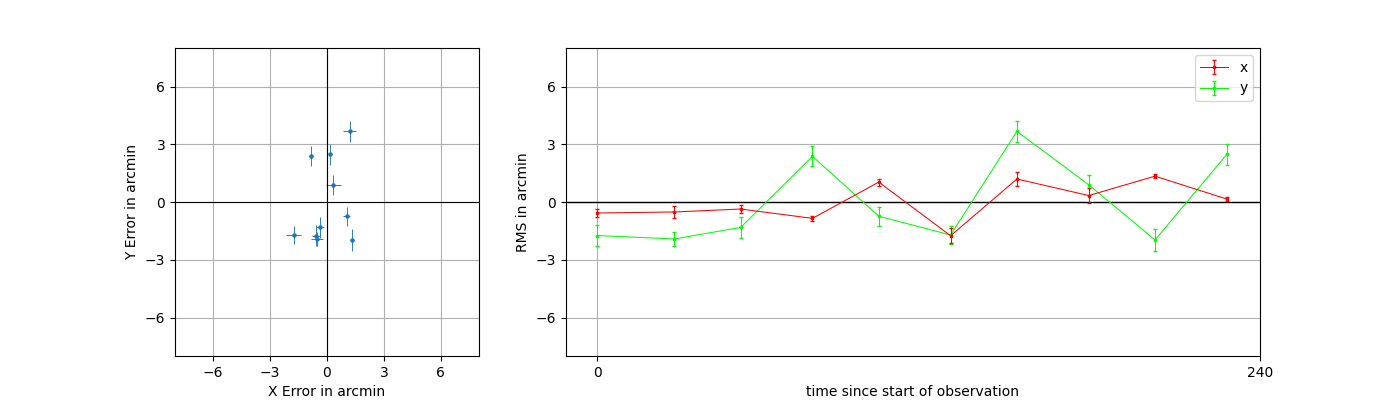

In [13]:
plt.close('all')
plt.figure(figsize=(14,4))
#plt.rcParams["font.family"] = "Times New Roman"

ax1=plt.subplot2grid((1, 3), (0, 0), colspan=1)
#plt.scatter(displacement[:,0]*60 - np.mean(displacement[:,0]*60), displacement[:,1]*60 - np.mean(displacement[:,1]*60), color='C0', s=4, zorder=3)
plt.scatter(pointing[:,0]*60 - np.mean(pointing[:,0]*60), pointing[:,1]*60 - np.mean(pointing[:,1]*60), color='C0', s=5, zorder=3)
plt.errorbar(pointing[:,0]*60 - np.mean(pointing[:,0]*60), pointing[:,1]*60 - np.mean(pointing[:,1]*60), xerr=pointing[:,3]*60, yerr=pointing[:,4]*60, linestyle='', linewidth=0.65, color='C0')
#plt.plot(displacement[:,0]*60 - np.mean(displacement[:,0]*60), displacement[:,1]*60 - np.mean(displacement[:,1]*60), color='C0', linewidth=0.7, alpha=0.5, zorder=0)


plt.axhline(color='k', linewidth=0.8, zorder=2)
plt.axvline(color='k', linewidth=0.8, zorder=2)
#plt.title('First Run', fontsize=15)
plt.grid()
plt.xticks(np.arange(-6,6.1,3))
plt.yticks(np.arange(-6,6.1,3))
plt.xlabel('X Error in arcmin')
plt.ylabel('Y Error in arcmin', rotation=90)
#plt.gca().set_aspect('equal')
plt.xlim(-8,8)
plt.ylim(-8,8)

ax2=plt.subplot2grid((1, 3), (0, 1), colspan=2)

plt.errorbar(times, pointing[:,0]*60 - np.mean(pointing[:,0]*60), yerr=pointing[:,3]*60, capsize=1.5, linestyle='-', color='r', linewidth = 0.75, label='x', marker='s', markersize=2, zorder=3)
plt.errorbar(times, pointing[:,1]*60 - np.mean(pointing[:,1]*60), yerr=pointing[:,4]*60, capsize=1.5, linestyle='-', color='lime', linewidth = 0.75, label='y', marker='s', markersize=2)

plt.ylabel('RMS in arcmin')
plt.xlabel('time since start of observation')

plt.ylim(-8,8)
#plt.xlim(-5,times[-1]-times[ref_idx]+15)
plt.yticks(np.arange(-6,6.1,3))
plt.xticks(np.arange(0,times[-1]-times[0]+15,240))
plt.axhline(color='k', linewidth=1)

plt.grid()
plt.legend()

plt.subplots_adjust(wspace=0.285)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


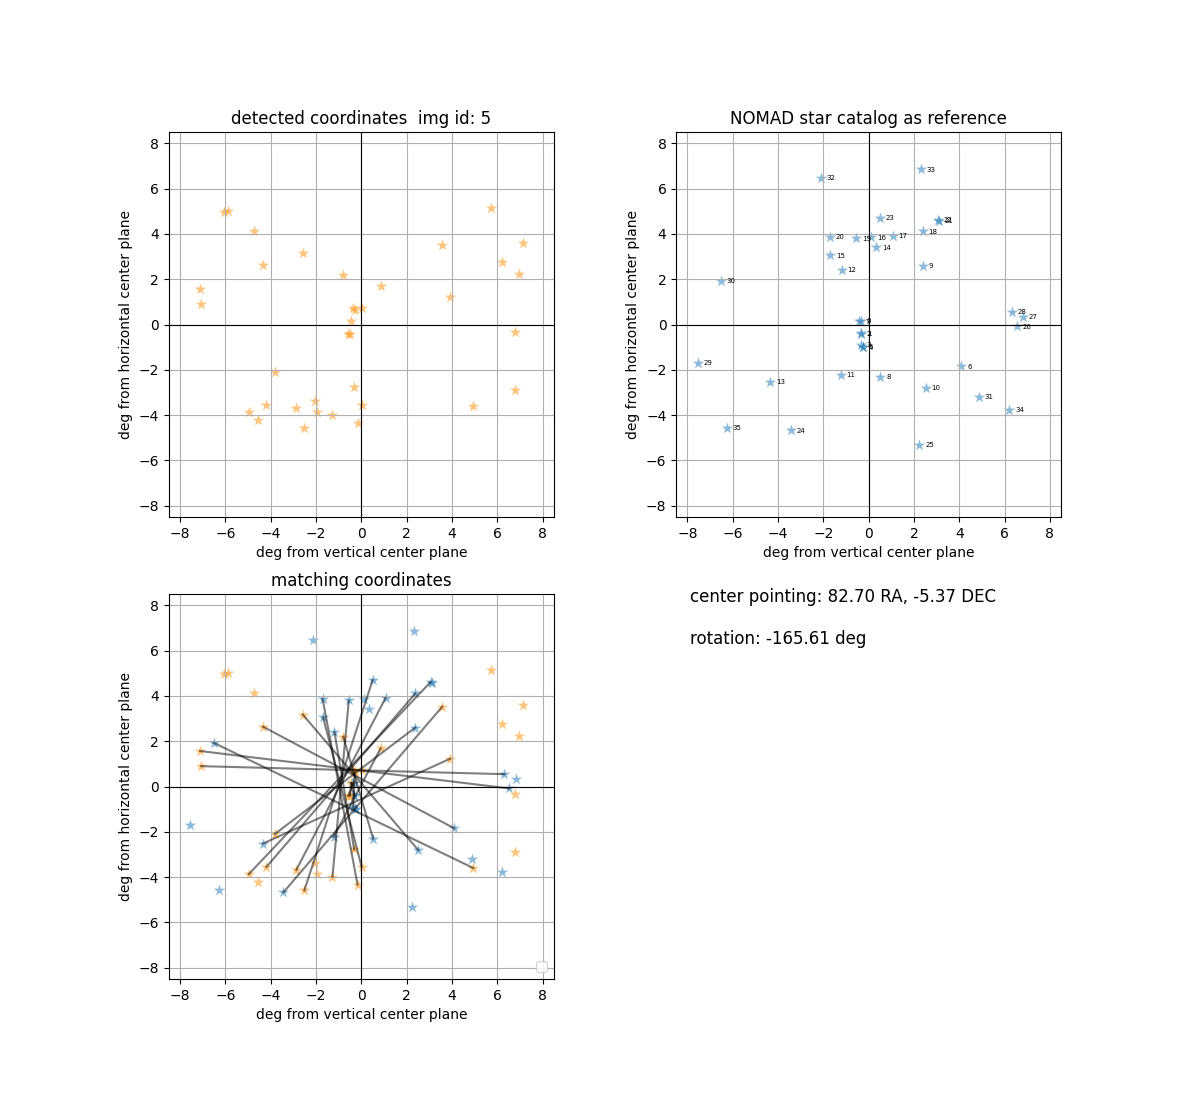

In [17]:
det_idx = 5

plt.close('all')
plt.figure(figsize=(12,11))


plt.subplot2grid((2, 2), (0, 0), colspan=1)
plt.scatter(coord_ang[det_idx][:,0], coord_ang[det_idx][:,1], color='darkorange', marker='*', alpha=0.5, s=75, linewidth=0)
plt.axhline(color='k', linewidth=0.8)
plt.axvline(color='k', linewidth=0.8)

plt.title('detected coordinates  img id: ' + str(det_idx))
plt.xlabel('deg from vertical center plane')
plt.ylabel('deg from horizontal center plane')
plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)
plt.xticks(np.arange(-8,8.1,2))
plt.yticks(np.arange(-8,8.1,2))
plt.grid()
plt.gca().set_aspect('equal')
##plt.gca().set_facecolor('k')


plt.subplot2grid((2, 2), (0, 1), colspan=1)
#plt.scatter(radec[ref_idx][:,0], radec[ref_idx][:,1], marker='*', alpha=0.5, s=75, linewidth=0)
plt.scatter(norm_star_coord[:,0], norm_star_coord[:,1], marker='*', alpha=0.5, s=75, linewidth=0)
plt.axhline(color='k', linewidth=0.8)
plt.axvline(color='k', linewidth=0.8)
#plot_triangle([tri1[0], tri1[1]])

for i in range(norm_star_coord.shape[0]):
    #plt.text(radec[ref_idx][i,0]+0.25, radec[ref_idx][i,1]-0.1, str(i), fontsize=5)
    plt.text(norm_star_coord[i,0]+0.25, norm_star_coord[i,1]-0.1, str(i), fontsize=5)

#plt.title('reference coordinates  img id: ' + str(ref_idx))
plt.title('NOMAD star catalog as reference')
plt.xlabel('deg from vertical center plane')
plt.ylabel('deg from horizontal center plane')
plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)
plt.xticks(np.arange(-8,8.1,2))
plt.yticks(np.arange(-8,8.1,2))
#plt.tick_params(labelleft = False)
plt.grid()
plt.gca().set_aspect('equal')


plt.subplot2grid((2, 2), (1, 0), colspan=1)

center = np.array([-2.25,-4])

plt.scatter(norm_star_coord[:,0], norm_star_coord[:,1], marker='*', s=75, alpha=0.5, linewidth=0)
plt.scatter(coord_ang[det_idx][:,0], coord_ang[det_idx][:,1], color='darkorange', marker='*', s=75, alpha=0.5, linewidth=0)
plt.axhline(color='k', linewidth=0.8)
plt.axvline(color='k', linewidth=0.8)
#plt.gca().add_patch(Rectangle((center[0]-.75,center[1]-.75), 1.5, 1.5, linewidth=0.8,linestyle='-',edgecolor='k',alpha=0.5,facecolor='none'))

for j in range(conn_stars[det_idx].shape[0]):
    plt.plot([conn_stars[det_idx][j][0], conn_stars[det_idx][j][2]],  [conn_stars[det_idx][j][1], conn_stars[det_idx][j][3]], 'k', alpha=0.5)
    #if j == 0: plt.scatter(conn_stars[det_idx-ref_idx][j][0], conn_stars[det_idx-ref_idx][j][1], color='lime', alpha=0.5, s=75, linewidth=0, zorder=2, marker='*', label='match')
    #else: plt.scatter(conn_stars[det_idx-ref_idx][j][0], conn_stars[det_idx-ref_idx][j][1], color='lime', alpha=0.5, s=75, linewidth=0, zorder=2, marker='*')

plt.text(14.5,6.3, 'center pointing: {0:.2f} RA, {1:.2f} DEC\n\nrotation: {2:.2f} deg'.format(pointing[det_idx][0], pointing[det_idx][1], pointing[det_idx][2]), fontsize=12)
plt.title('matching coordinates')
plt.xlabel('deg from vertical center plane')
plt.ylabel('deg from horizontal center plane')
plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)
plt.xticks(np.arange(-8,8.1,2))
plt.yticks(np.arange(-8,8.1,2))
#plt.tick_params(labelleft = False)
plt.legend(loc='lower right')
plt.grid()
plt.gca().set_aspect('equal')

plt.show()

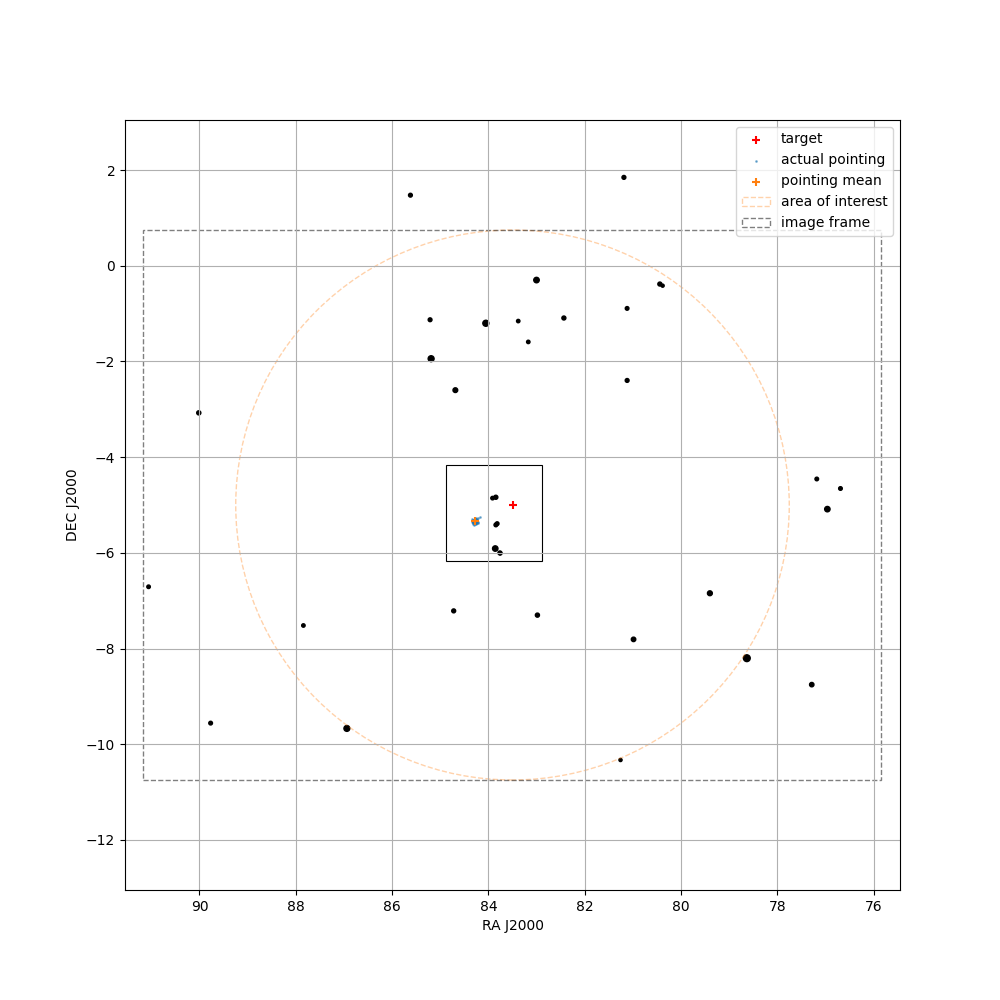

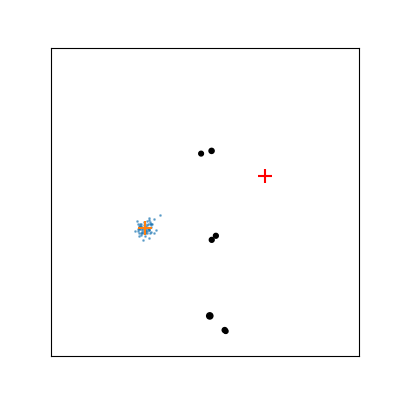

In [47]:

#norm_tgt = [-(i-tgt_coord[0]), j-tgt_coord[1]]

#angle = np.radians(rot_angle.mean(axis=0)*0)

#rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]])

#p =  np.dot(rotation_matrix, displacement.T).T
#pt = np.array([tgt_coord[0]-p[:,0], tgt_coord[1]+p[:,1]])

center = (tgt_coord[0]+displacement[:,0].mean()/2, tgt_coord[1]+displacement[:,1].mean()/2)

fov = np.array([[i,j] for i, j in zip([0, 0, corr_images[0].shape[1], corr_images[0].shape[1]], [0, corr_images[0].shape[0], 0, corr_images[0].shape[0]])]).astype('int')

ra_lim, dec_lim = pxl_to_angle(fov)
ra_lim, dec_lim = ra_lim * 180/math.pi, dec_lim * 180/math.pi

#pt = np.array([tgt_coord[0]+p[:,0], tgt_coord[1]-p[:,1]]).T

plt.close('all')
fig, ax = plt.subplots(figsize=(10, 10))
#plt.grid()

plt.scatter(x['RAJ2000'], x['DEJ2000'], marker='o', color='k', s=norm_vmag*20+5)
plt.scatter(tgt_coord[0], tgt_coord[1], marker='+', color='r', label='target')
plt.scatter(tgt_coord[0]+displacement[:,0], tgt_coord[1]+displacement[:,1], color='C0', label='actual pointing', alpha=0.5, s=1)
#plt.scatter(tgt_coord[0]-displacement[:,0].mean(), tgt_coord[1]+displacement[:,1].mean(), marker='+', color='C2', label='pointing mean 1', alpha=1)
#plt.scatter(tgt_coord[0]-displacement1[:,0], tgt_coord[1]+displacement1[:,1], color='C0', alpha=0.5, s=1)
#plt.scatter(tgt_coord[0]-displacement1[:,0].mean(), tgt_coord[1]+displacement1[:,1].mean(), marker='+', color='C3', label='pointing mean 0', alpha=1)
plt.scatter(tgt_coord[0]+displacement[:,0].mean(), tgt_coord[1]+displacement[:,1].mean(), marker='+', color='C1', label='pointing mean', alpha=1)
#plt.scatter(pt[:,0], pt[:,1], color='C0', label='rot pointing (run 1)', alpha=1, s=100)
#plt.gca().add_patch(plt.Circle((tgt_coord[0], tgt_coord[1]), 10, linewidth=1, linestyle='--', edgecolor='r', alpha=0.5, facecolor='none', label='possible target area'))
plt.gca().add_patch(plt.Circle((tgt_coord[0], tgt_coord[1]), dec_lim[0], linewidth=1, linestyle='--', edgecolor='C1', alpha=0.35, facecolor='none', label='area of interest'))
plt.gca().add_patch(Rectangle((tgt_coord[0]-ra_lim[0], tgt_coord[1]-dec_lim[0]), -2*ra_lim[3], -2*dec_lim[3], linewidth=1,linestyle='--',edgecolor='k',alpha=0.5,facecolor='none', label='image frame', angle=0))
plt.gca().add_patch(Rectangle((center[0]+1, center[1]-1), -2, 2, linewidth=0.8,linestyle='-',edgecolor='k',alpha=1,facecolor='none'))

#plt.gca().add_patch(Rectangle((tgt_coord[0]+ra_lim[0], tgt_coord[1]+dec_lim[0]),2*ra_lim[3], 2*dec_lim[3],linewidth=1,linestyle='--',edgecolor='red',alpha=0.5,facecolor='none', label='image frame'))

ax.set_yticks(range(-90,91, 2))
ax.set_ylim(tgt_coord[1]+ra_lim[0]*1.05, tgt_coord[1]-ra_lim[0]*1.05)
ax.set_xticks(range(0,361, 2))
ax.set_xlim(tgt_coord[0]-ra_lim[0]*1.05, tgt_coord[0]+ra_lim[0]*1.05)

#plt.title('NOMAD catalog Vmag < {}'.format(Vmag_limit), pad=30)
#plt.title('NOMAD catalog Vmag < {}'.format(Vmag_limit), pad=30)
plt.xlabel('RA J2000')
plt.ylabel('DEC J2000')
plt.legend()
plt.grid()

plt.show()

fig, ax = plt.subplots(figsize=(4, 4))

plt.scatter(x['RAJ2000'], x['DEJ2000'], marker='o', color='k', s=norm_vmag*20+10)
plt.scatter(tgt_coord[0], tgt_coord[1], marker='+', color='r', label='target', s=100)
plt.scatter(tgt_coord[0]+displacement[:,0], tgt_coord[1]+displacement[:,1], color='C0', label='actual pointing', alpha=0.5, s=1)
#plt.scatter(tgt_coord[0]-displacement1[:,0], tgt_coord[1]+displacement1[:,1], color='C0', alpha=0.5, s=1)

plt.scatter(tgt_coord[0]+displacement[:,0].mean(), tgt_coord[1]+displacement[:,1].mean(), marker='+', color='C1', label='pointing mean', alpha=1, s=100)

plt.gca().set_aspect('equal')
ax.set_yticks(range(-90,91, 10))
ax.set_ylim(center[1]-1, center[1]+1)
ax.set_xticks(range(0,361, 10))
ax.set_xlim(center[0]+1, center[0]-1)

plt.show()
#print(pt)


#print(x.sort_values('Vmag'))
#print(((displacement.mean(axis=0))-(displacement1.mean(axis=0)))*60)

In [ ]:
pointing[3]

: 

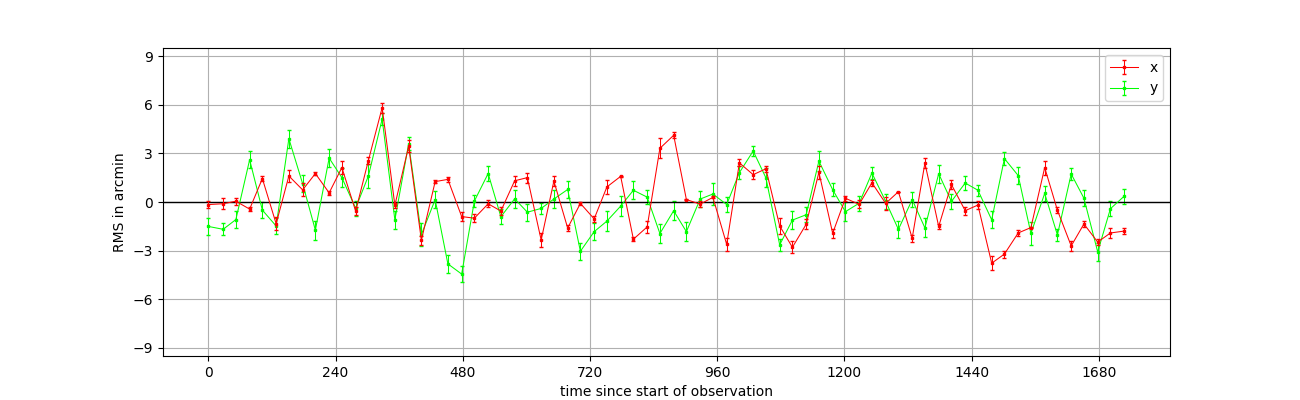

In [124]:
angle = np.radians(pointing[3])

rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                            [np.sin(angle), np.cos(angle)]])

rotated_stars = np.dot(rotation_matrix, conn_stars[0][:,0:2].T).T + displacement[0]

plt.close('all')
plt.figure(figsize=(8,8))

plt.scatter(conn_stars[0][:,2], conn_stars[0][:,3])
plt.scatter(rotated_stars[:,0], rotated_stars[:,1])

plt.show()